In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix # Chỉ dùng để verify kết quả visual


In [2]:

# --- 1. SETUP PATH ---
# Tự động tìm thư mục src
current_dir = os.getcwd()
path_option_1 = os.path.join(current_dir, 'src')
path_option_2 = os.path.abspath(os.path.join(current_dir, '..', 'src'))

if os.path.exists(os.path.join(path_option_1, 'models.py')):
    sys.path.append(path_option_1)
elif os.path.exists(os.path.join(path_option_2, 'models.py')):
    sys.path.append(path_option_2)

# Import model tự viết
from models import LogisticRegression


In [3]:

# --- 2. LOAD PROCESSED DATA ---
# Tìm đường dẫn file .npy
data_dir = 'data/processed'
if not os.path.exists(data_dir):
    data_dir = '../data/processed'

print(f"Loading data from: {data_dir}")

try:
    X_train = np.load(os.path.join(data_dir, 'X_train.npy'))
    X_test = np.load(os.path.join(data_dir, 'X_test.npy'))
    y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
    y_test = np.load(os.path.join(data_dir, 'y_test.npy'))
    print(f"✅ Load thành công! Train shape: {X_train.shape}, Test shape: {X_test.shape}")
except FileNotFoundError:
    print("❌ Lỗi: Không tìm thấy file .npy. Hãy chạy notebook 02_preprocessing trước!")


Loading data from: ../data/processed
✅ Load thành công! Train shape: (15326, 12), Test shape: (3832, 12)


In [4]:
# --- 3. TRAINING WITH SMOTE & CV ---
from models import LogisticRegression, SMOTE, cross_val_score

print(f"Dữ liệu gốc (Train): {np.bincount(y_train.astype(int))}")

# 1. SMOTE
print("⏳ Đang chạy SMOTE...")
smote = SMOTE(k_neighbors=5, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(f"Dữ liệu sau SMOTE: {np.bincount(y_train_res.astype(int))}")

# 2. Cross-Validation
print("\n⏳ Đang chạy Cross-Validation (5 folds)...")
# CHIẾN THUẬT: Learning Rate cực nhỏ + Số vòng lặp cực lớn
cv_model = LogisticRegression(learning_rate=0.001, n_iterations=30000, lambda_reg=0.01)
cv_scores = cross_val_score(cv_model, X_train_res, y_train_res, n_folds=5)
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f}")

# 3. Huấn luyện Final Model
print("\n⏳ Đang huấn luyện Final Model...")
final_model = LogisticRegression(learning_rate=0.001, n_iterations=30000, lambda_reg=0.01)
final_model.fit(X_train_res, y_train_res)
print("✅ Huấn luyện hoàn tất!")

Dữ liệu gốc (Train): [11499  3827]
⏳ Đang chạy SMOTE...
Dữ liệu sau SMOTE: [11499 11499]

⏳ Đang chạy Cross-Validation (5 folds)...
Cross-Validation Accuracy Scores: [0.6499239  0.64666232 0.65818656 0.64470537 0.65840939]
Mean CV Accuracy: 0.6516

⏳ Đang huấn luyện Final Model...
✅ Huấn luyện hoàn tất!


============================== BẮT ĐẦU ĐÁNH GIÁ ==============================
⏳ Đang train Sklearn model để so sánh...

-------------------------------------------------------------------------------------
Metric               My Model (NumPy)          Sklearn (Library)         Chênh lệch     
-------------------------------------------------------------------------------------
Accuracy             0.6587                    0.7784                    0.1198         
Precision            0.3851                    0.6105                    0.2254         
Recall               0.6316                    0.2937                    0.3379         
F1-Score             0.4785                    0.3966                    0.0819         
-------------------------------------------------------------------------------------

📍 Vị trí Kernel hiện tại: /home/kehuydiet/monhoc/khdl/HR_Analytics_Project/notebooks
📁 Sử dụng thư mục ảnh: /home/kehuydiet/monhoc/khdl/HR_Analytics_Project/IMG
📸 Đang lưu biể

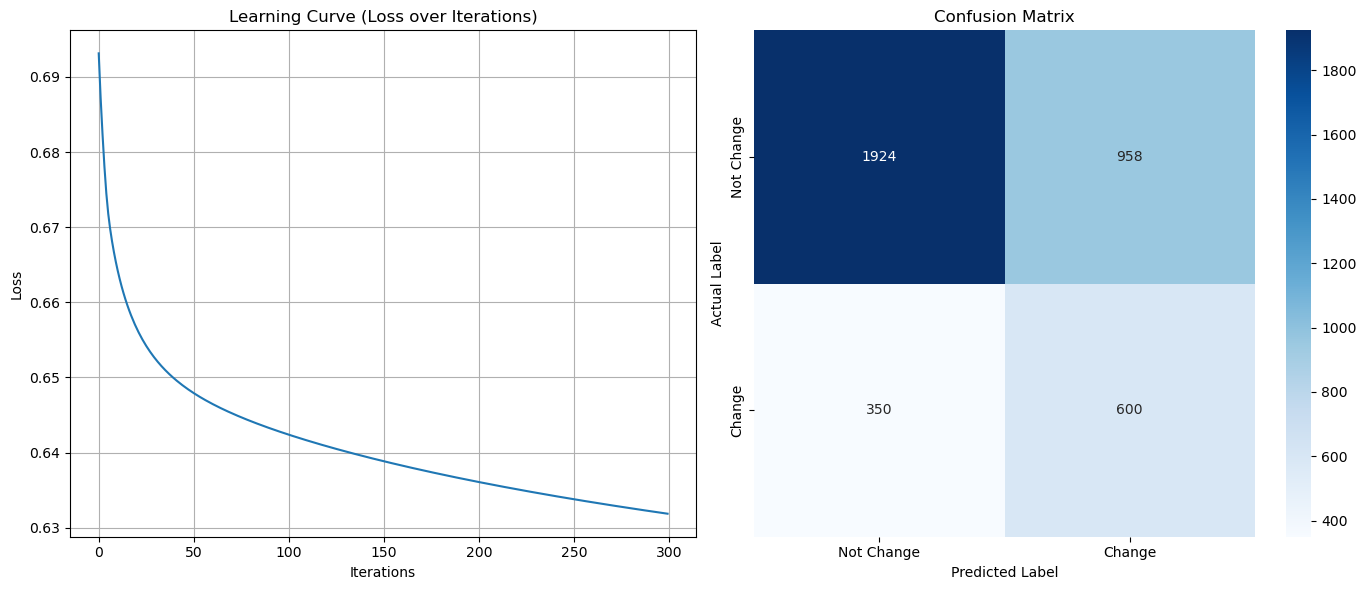


✅ HOÀN TẤT! Ảnh đã được lưu chính xác.


In [5]:
# --- 4. ĐÁNH GIÁ TOÀN DIỆN & SO SÁNH & LƯU ẢNH ---
from sklearn.linear_model import LogisticRegression as SklearnLR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from visualization import plot_learning_curve_and_confusion_matrix
import os
import numpy as np

print("="*30 + " BẮT ĐẦU ĐÁNH GIÁ " + "="*30)

# =========================================
# 1. ĐÁNH GIÁ MODEL CỦA BẠN
# =========================================
my_pred = final_model.predict(X_test, threshold=0.5)

TP = np.sum((my_pred == 1) & (y_test == 1))
TN = np.sum((my_pred == 0) & (y_test == 0))
FP = np.sum((my_pred == 1) & (y_test == 0))
FN = np.sum((my_pred == 0) & (y_test == 1))

accuracy = (TP + TN) / len(y_test)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# =========================================
# 2. ĐÁNH GIÁ SKLEARN
# =========================================
print("⏳ Đang train Sklearn model để so sánh...")
sk_model = SklearnLR(max_iter=5000)
sk_model.fit(X_train, y_train)
sk_pred = sk_model.predict(X_test)

sk_acc = accuracy_score(y_test, sk_pred)
sk_prec = precision_score(y_test, sk_pred)
sk_rec = recall_score(y_test, sk_pred)
sk_f1 = f1_score(y_test, sk_pred)

# =========================================
# 3. IN BẢNG SO SÁNH
# =========================================
print("\n" + "-"*85)
print(f"{'Metric':<20} {'My Model (NumPy)':<25} {'Sklearn (Library)':<25} {'Chênh lệch':<15}")
print("-" * 85)
print(f"{'Accuracy':<20} {accuracy:<25.4f} {sk_acc:<25.4f} {abs(accuracy-sk_acc):<15.4f}")
print(f"{'Precision':<20} {precision:<25.4f} {sk_prec:<25.4f} {abs(precision-sk_prec):<15.4f}")
print(f"{'Recall':<20} {recall:<25.4f} {sk_rec:<25.4f} {abs(recall-sk_rec):<15.4f}")
print(f"{'F1-Score':<20} {f1:<25.4f} {sk_f1:<25.4f} {abs(f1-sk_f1):<15.4f}")
print("-" * 85)

# =========================================
# 4. XỬ LÝ ĐƯỜNG DẪN THÔNG MINH (QUAN TRỌNG)
# =========================================
current_dir = os.getcwd()
print(f"\n📍 Vị trí Kernel hiện tại: {current_dir}")

# Logic tìm Project Root:
# Nếu thấy folder 'src' ngay đây -> Đang ở Root
# Nếu thấy folder 'src' ở cấp cha (..) -> Đang ở subfolder (vd: notebooks)
if os.path.exists(os.path.join(current_dir, 'src')):
    project_root = current_dir
elif os.path.exists(os.path.join(current_dir, '..', 'src')):
    project_root = os.path.abspath(os.path.join(current_dir, '..'))
else:
    # Trường hợp hiếm: không tìm thấy cấu trúc chuẩn, fallback về hiện tại
    project_root = current_dir
    print("⚠️ Cảnh báo: Không tự động nhận diện được cấu trúc dự án. Sử dụng thư mục hiện tại.")

img_dir = os.path.join(project_root, 'IMG')

# Tạo thư mục nếu chưa có
if not os.path.exists(img_dir):
    try:
        os.makedirs(img_dir)
        print(f"📁 Đã tạo thư mục ảnh mới: {img_dir}")
    except OSError as e:
        print(f"❌ Không thể tạo thư mục (Lỗi quyền hạn?): {e}")
        img_dir = current_dir # Fallback lưu tại chỗ nếu lỗi
else:
    print(f"📁 Sử dụng thư mục ảnh: {img_dir}")

# Đường dẫn file ảnh
save_path = os.path.join(img_dir, 'training_result.png')

# =========================================
# 5. VẼ VÀ LƯU
# =========================================
print(f"📸 Đang lưu biểu đồ vào: {save_path}")
cm = np.array([[TN, FP], [FN, TP]])
try:
    plot_learning_curve_and_confusion_matrix(final_model.loss_history, cm, save_path=save_path)
    print("\n✅ HOÀN TẤT! Ảnh đã được lưu chính xác.")
except Exception as e:
    print(f"\n❌ Lỗi khi lưu ảnh: {e}")